In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from tensorflow import keras 
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## <b style="color:red;">LOADING AND PREPROCESSING THE DATASET</b>

In [2]:
#define object to load and preprocess the data
class get_dataset:
    '''
    Object for loading and preprocess the dataset
    ARGS: 
    augmentation: bool. Whether to apply image augmentation. Default = False
    batch_size: int: Required batch size of the dataset. Default = 16
    image_size: tuple: Required training image size. Default = (256,256)
    '''
    def __init__(self, augmentation = False, batch_size = 16, image_size = (256,256)):
        self.augmentation = augmentation
        self.batch_size = batch_size
        self.image_size = image_size
        
        if self.augmentation:
            self.datagen = ImageDataGenerator(
                            rotation_range = 3,
                             width_shift_range = 0.03,
                             height_shift_range = 0.03,
                             shear_range = 0.03,
                             zoom_range = 0.03,
                             horizontal_flip = True,
                             vertical_flip = True,
                             fill_mode ='nearest',
                             rescale = 1./255,
                             validation_split = 0.1)
            
    def visualize_augmentation(self, sample_img_1, sample_img_2):
        '''
        Function for visualizing the augmentation
        '''
        img_1 = plt.imread(sample_img_1)
        img_2 = plt.imread(sample_img_2)

        fig, axs = plt.subplots(2, 2,sharex='col', sharey='row')
        axs[0, 0].imshow(img_1)
        axs[0, 0].set_title("Image 1")
        axs[1, 0].imshow(img_2)
        axs[1, 0].set_title("Image 2")

        axs[0, 1].imshow(self.datagen.random_transform(img_1))
        axs[0, 1].set_title("Augmented Image")
        axs[1, 1].imshow(self.datagen.random_transform(img_2))
        axs[1, 1].set_title("Augmented Image")
        fig.suptitle('Visualizing the Effect of Augmentation')
        fig.tight_layout();
    
    def dataset(self, root_dir):
        '''
        ARGS:
        root_dir: string. The directory of the data. with each sub directory perclass.
        RETURNS:
        A tuple of training and validation datasets or data generator. 
        '''
        
        if self.augmentation:
            normalized_train_gen = self.datagen.flow_from_directory(root_dir,
                                              batch_size = self.batch_size,
                                              class_mode = "categorical",
                                              subset = 'training',
                                              target_size = self.image_size)

            normalized_val_gen= self.datagen.flow_from_directory(root_dir,
                                              batch_size = self.batch_size,
                                              class_mode = "categorical",
                                              subset = 'validation',
                                              target_size = self.image_size)
            
            return (normalized_train_gen, normalized_val_gen)

        else:           
            train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(root_dir,
              image_size = self.image_size,
              batch_size = self.batch_size,
              label_mode = None,
              validation_split = 0.1,
              subset = 'both',
              seed = 45)
 
            normalization_layer = layers.Rescaling(scale= 1./255) 
 
            normalized_train_ds = train_ds.map(lambda x: normalization_layer(x))
            normalized_val_ds = val_ds.map(lambda x: normalization_layer(x))
            return (normalized_train_ds, normalized_val_ds)



In [3]:
#Provide the path to the dataset (root_dir) and/or any sample images (to visualize the effect of augmentation
root_dir = 
sample_img_1 = 
sample_img_2 = 

dataset = get_dataset(True)
train_data,val_data = dataset.dataset(root_dir)

Found 490 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


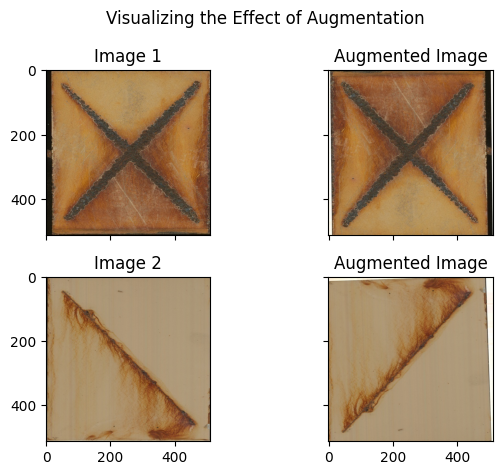

In [17]:
#Visualize image augmentation
dataset.visualize_augmentation(sample_img_1,sample_img_2)


## <b style="color: red;">SAMPLING TECHNIQUE FOR THE LATENT SPACE</b>


In [6]:
#sampling_reparameterization function--- Function for generating samples
def sampling_reparameterization(distribution_params):
    mean, log_var = distribution_params
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mean), mean=0., stddev=1.)
    z = mean + tf.keras.backend.exp(log_var / 2) * epsilon
    
    return z

In [7]:
#the sampling network
latent_dim = 10 #dimension of the latent space

def sampling(input_1,input_2):
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_reparameterization, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    
    return enc_2
sampler = sampling(latent_dim, latent_dim)

## <b style="color: red;">LOSS FUNCTION AND OPTIMIZER FOR TRAINING</b>

In [8]:
initial_learning_rate = 0.001
decay_steps = 400
decay_rate = 0.7
staircase = True

# Create the learning rate schedule
learning_rate_fn = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,decay_steps, decay_rate, staircase=staircase)

# Define the optimizer
optimizer_1 = tf.optimizers.Adam(learning_rate=learning_rate_fn)
optimizer_2 = tf.optimizers.Adam(learning_rate=learning_rate_fn)

#Define scaling factor for loss functions
beta = 660
 
def mse_loss(y_true, y_pred):
    r_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred), axis = [1,2,3])
    return r_loss
 
def kl_loss(mean, log_var):
    kl_loss =  -0.5 * tf.keras.backend.sum(1 + log_var - tf.keras.backend.square(mean) - tf.keras.backend.exp(log_var), axis = 1)
    return kl_loss
 
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    KL_loss = kl_loss(mean, log_var)
    training_loss = (beta*r_loss) + KL_loss
    
    return training_loss

## <b style="color: red;">THE ENCODER</b>

In [9]:
def encoder(input_encoder):
     
     
    inputs = keras.Input(shape=input_encoder, name='input_layer')
     
    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
  
 
    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(latent_dim, name='mean')(flatten)
    log_var = layers.Dense(latent_dim, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

image_size = (256,256)
enc = encoder((*image_size,3))
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 128, 32  896         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 bn_1 (BatchNormalization)      (None, 128, 128, 32  128         ['conv_1[0][0]']                 
                                )                                                           

## <b style="color: red;">THE DECODER</b>

In [10]:
#build the decoder
def decoder(input_decoder):
     
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)
     
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
  
    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block-4
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
 
   
    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model
dec = decoder((latent_dim,))
dec.summary()


Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              45056     
                                                                 
 Reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 64)        0         
                                                           

## <b style="color: red;">CUSTOM TRAINING LOOP</b>

In [11]:
@tf.function
def train_step(train_images):
 
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
       
       
        mean, log_var = enc(train_images, training=True)
        latent = sampler([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(train_images, generated_images, mean, log_var)
        MSE =  mse_loss(train_images, generated_images)
        KLE = kl_loss(mean, log_var)

         
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
     
    optimizer_1.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer_2.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss,MSE,KLE


def val_step(val_images):
  mean, log_var = enc(val_images)
  latent = sampler([mean, log_var])
  generated_images_val = dec(latent)
  val_loss = mse_loss(val_images, generated_images_val)

  return val_loss
        

In [12]:
training_loss_list = []
mse_loss_list = []
kl_loss_list = []
val_mse_list = []

#define object for custom training
class train:
    '''
    Object for custom training
    ARGS:
    augmentation: bool. Whether image augmentation was done in the loading
                        and preprocessing stages.
    '''
    def __init__(self, augmentation = False):
        self.augmentation = augmentation
    def train(self,train_dataset,val_dataset = None, epochs = 50):
        if self.augmentation:           
            for epoch in range(epochs):
                train_count = 0
                val_count = 0
                epoch_loss = []
                epoch_mse_loss = []
                epoch_kl_loss = []
                epoch_val_loss=[]

                start = time.time()
                for image_batch in train_dataset:
                  train_count+=1
                  loss,MSE,KLE = train_step(image_batch)
                  epoch_loss.append(np.mean(loss))
                  epoch_mse_loss.append(np.mean(MSE))
                  epoch_kl_loss.append(np.mean(KLE))
                  if train_count == 25:
                    break 

                if val_dataset:
                  for image_batch in val_dataset:
                    val_count+=1
                    val_loss =np.mean(val_step(image_batch))
                    epoch_val_loss.append(val_loss)
                    if val_count == 5:
                      break 
                  epoch_val_loss = np.mean(epoch_val_loss)

                epoch_loss = np.mean(epoch_loss)
                epoch_mse_loss = np.mean(epoch_mse_loss)
                epoch_kl_loss = np.mean(epoch_kl_loss)

                training_loss_list.append(epoch_loss)
                mse_loss_list.append(epoch_mse_loss)
                kl_loss_list.append(epoch_kl_loss)
                val_mse_list.append(epoch_val_loss)


                print(f'epoch: {epoch+1} || Training Loss:{epoch_loss:.4f} || MSE:{epoch_mse_loss:.4f} || KL_Loss: {epoch_kl_loss:.4f} || Val_MSE:{epoch_val_loss:.4f} || time {time.time()-start:.4f}')


        else:
              for epoch in range(epochs):
                epoch_loss = []
                epoch_mse_loss = []
                epoch_kl_loss = []
                epoch_val_loss=[]

                start = time.time()
                for image_batch in train_dataset:
                  loss,MSE,KLE = train_step(image_batch)
                  epoch_loss.append(np.mean(loss))
                  epoch_mse_loss.append(np.mean(MSE))
                  epoch_kl_loss.append(np.mean(KLE))


                if val_dataset:
                  for image_batch in val_dataset:
                    val_mse =np.mean(val_step(image_batch))
                    epoch_val_loss.append(val_mse)
                  epoch_val_loss = np.mean(epoch_val_loss)



                epoch_loss = np.mean(epoch_loss)
                epoch_mse_loss = np.mean(epoch_mse_loss)
                epoch_kl_loss = np.mean(epoch_kl_loss)

                training_loss_list.append(epoch_loss)
                mse_loss_list.append(epoch_mse_loss)
                kl_loss_list.append(epoch_kl_loss)
                val_mse_list.append(epoch_val_loss)

                print(f'epoch: {epoch+1} || Training Loss:{epoch_loss:.4f} || MSE:{epoch_mse_loss:.4f} || KL_Loss: {epoch_kl_loss:.4f} || Val_MSE:{epoch_val_loss:.4f} || time {time.time()-start:.4f}')



In [13]:
#train for 120 epochs 
train_loop = train(augmentation = True)
train_loop.train(train_dataset=train_data, val_dataset = val_data, epochs = 120)

epoch: 1 || Training Loss:37.8046 || MSE:0.0488 || KL_Loss: 5.5667 || Val_MSE:0.0348 || time 38.4098
epoch: 2 || Training Loss:24.5358 || MSE:0.0289 || KL_Loss: 5.4427 || Val_MSE:0.0293 || time 29.9962
epoch: 3 || Training Loss:18.8010 || MSE:0.0225 || KL_Loss: 3.9360 || Val_MSE:0.0272 || time 29.6111
epoch: 4 || Training Loss:17.9168 || MSE:0.0224 || KL_Loss: 3.1618 || Val_MSE:0.0238 || time 28.4561
epoch: 5 || Training Loss:15.3635 || MSE:0.0189 || KL_Loss: 2.8630 || Val_MSE:0.0230 || time 27.0315
epoch: 6 || Training Loss:14.3373 || MSE:0.0173 || KL_Loss: 2.9216 || Val_MSE:0.0223 || time 36.4049
epoch: 7 || Training Loss:14.3115 || MSE:0.0178 || KL_Loss: 2.5849 || Val_MSE:0.0198 || time 41.8131
epoch: 8 || Training Loss:13.3701 || MSE:0.0164 || KL_Loss: 2.5338 || Val_MSE:0.0180 || time 41.8758
epoch: 9 || Training Loss:12.4189 || MSE:0.0152 || KL_Loss: 2.3932 || Val_MSE:0.0198 || time 43.8178
epoch: 10 || Training Loss:13.3667 || MSE:0.0164 || KL_Loss: 2.5337 || Val_MSE:0.0186 || ti

epoch: 82 || Training Loss:11.3719 || MSE:0.0134 || KL_Loss: 2.5435 || Val_MSE:0.0147 || time 41.7020
epoch: 83 || Training Loss:10.5959 || MSE:0.0126 || KL_Loss: 2.2719 || Val_MSE:0.0118 || time 40.9526
epoch: 84 || Training Loss:10.7561 || MSE:0.0126 || KL_Loss: 2.4529 || Val_MSE:0.0118 || time 40.1032
epoch: 85 || Training Loss:11.3452 || MSE:0.0136 || KL_Loss: 2.3762 || Val_MSE:0.0114 || time 43.1451
epoch: 86 || Training Loss:10.6877 || MSE:0.0127 || KL_Loss: 2.2754 || Val_MSE:0.0117 || time 40.5006
epoch: 87 || Training Loss:10.5056 || MSE:0.0123 || KL_Loss: 2.3626 || Val_MSE:0.0117 || time 40.7185
epoch: 88 || Training Loss:10.9896 || MSE:0.0131 || KL_Loss: 2.3676 || Val_MSE:0.0128 || time 42.0198
epoch: 89 || Training Loss:11.4996 || MSE:0.0136 || KL_Loss: 2.5273 || Val_MSE:0.0104 || time 40.7447
epoch: 90 || Training Loss:10.9487 || MSE:0.0131 || KL_Loss: 2.2874 || Val_MSE:0.0107 || time 41.7913
epoch: 91 || Training Loss:11.2691 || MSE:0.0135 || KL_Loss: 2.3318 || Val_MSE:0.0

## <b style="color: red;">VISUALIZE PERFORMANCE OF THE VAE</b>

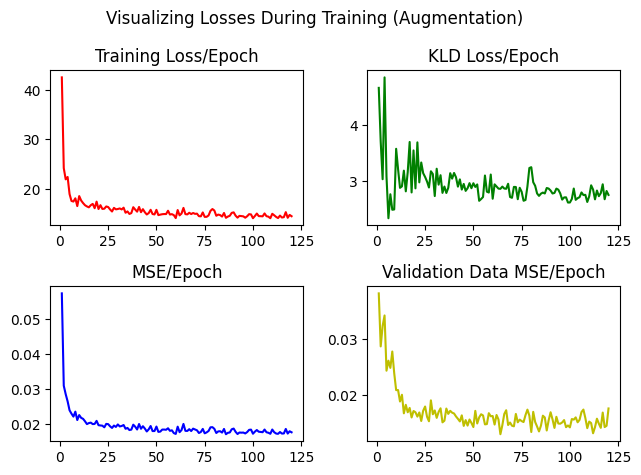

In [12]:
num_of_epochs = 120
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(1,num_of_epochs+1), training_loss_list,'r')
axs[0, 0].set_title("Training Loss/Epoch")
axs[1, 0].plot(range(1,num_of_epochs+1), mse_loss_list,'b')
axs[1, 0].set_title("MSE/Epoch")

axs[0, 1].plot(range(1,num_of_epochs+1), kl_loss_list,'g')
axs[0, 1].set_title("KLD Loss/Epoch")
axs[1, 1].plot(range(1,num_of_epochs+1), val_mse_list,'y')
axs[1, 1].set_title("Validation Data MSE/Epoch")
fig.suptitle('Visualizing Losses During Training (Augmentation)')
fig.tight_layout()


1/1 [==============================] - 1s 700ms/step


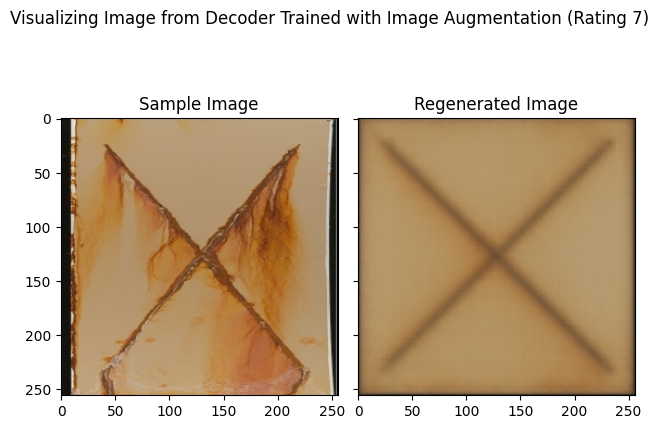

In [14]:
#select different image samples and regenerate them.
sample_img_5a = 
sample_img_9a = 
sample_img_9b = 
sample_img_7a = 
sample_img_7b = 

#using a sample image from class 7 (sample_img_7a)
img_1 = plt.imread(sample_img_7a)

sample = tf.keras.Sequential([layers.Resizing(256,256, input_shape = (512,512,3)),
                              layers.Rescaling(scale= 1./255)])
                             
sample_1 = sample(np.expand_dims(img_1, axis = 0)).numpy()

m, v = enc.predict(sample_1)
latent = sampler([m,v])

reconst = dec.predict(m)
reconst = np.reshape(reconst,(256,256,3))

fig, (axs_1,axs_2) = plt.subplots(1, 2, sharey='row')
axs_1.imshow(np.squeeze(sample_1))
axs_1.set_title("Sample Image")

axs_2.imshow(reconst)
axs_2.set_title("Regenerated Image")
fig.suptitle('Visualizing Image from Decoder Trained with Image Augmentation (Rating 7)')
fig.tight_layout()


In [6]:
import os
from PIL import Image
import warnings
import seaborn as sns
from sklearn.decomposition import PCA


warnings.filterwarnings('ignore')

In [10]:
#Create a dataframe of all images and their corresponding labels.


#Create an empty dataframe
df = pd.DataFrame(columns=['image', 'label'])
#Iterate over the sub directories within the root directory
for dirs, subdirs, files in os.walk(root_Dir):
  for file in files:
    file_path = os.path.join(dirs, file)
    
    #load the image
    with Image.open(file_path) as img:
      #convert image to numpy array
      img_array = np.array(img)
      #Extract the label
      label = os.path.basename(dirs)
      #Add the image and label to the dataframe
      df = df.append({'image':img_array, 'label':label}, ignore_index = True)
# df = df.sample(frac = 1).reset_index(drop = True)
df.head(10)

,image,label
0,"[[[250, 255, 246], [239, 245, 235], [246, 247,...",5
1,"[[[244, 255, 241], [243, 249, 235], [247, 241,...",5
2,"[[[255, 249, 231], [248, 240, 221], [255, 243,...",5
3,"[[[253, 255, 247], [241, 247, 237], [244, 250,...",5
4,"[[[255, 242, 222], [246, 229, 211], [244, 230,...",5
5,"[[[255, 255, 250], [18, 17, 12], [18, 17, 13],...",5
6,"[[[255, 252, 249], [250, 247, 242], [255, 250,...",5
7,"[[[255, 255, 246], [243, 239, 230], [245, 238,...",5
8,"[[[255, 249, 232], [251, 244, 228], [247, 245,...",5
9,"[[[249, 255, 238], [242, 246, 229], [244, 240,...",5


In [9]:
batch_size = 16
y = df['label']
X = df['image'].values
X = np.stack(X)

preprocessing_model = tf.keras.Sequential()
preprocessing_model.add(tf.keras.Input(shape=(512,512,3)))
preprocessing_model.add(tf.keras.layers.Resizing(256,256))
preprocessing_model.add(tf.keras.layers.Rescaling(scale= 1./255))
X1 = preprocessing_model.predict(X)

MEAN,VAR = enc.predict(X1, batch_size=batch_size)


In [18]:
enc_df = pd.DataFrame(MEAN)
enc_df['Label'] = y
enc_df['Label'] = enc_df['Label'].apply(lambda x :int(x))
# enc_df = enc_df.sample(frac = 1).reset_index(drop = True)
enc_df.head()

,0,1,2,3,4,5,6,7,8,9,Label
0,-0.003887,-0.014841,0.059205,-0.036197,-0.046776,-1.573577,-0.113323,-0.004830,1.475658,-0.020013,6
1,-0.552986,-0.097348,-0.018708,0.070186,-0.006839,1.570390,-0.013336,-0.046314,1.197977,0.014907,6
2,-0.147451,-0.125417,-0.059317,0.018573,0.094161,1.346891,0.012871,-0.002016,2.166505,0.008809,6
3,0.850513,0.053930,-0.011675,0.026337,0.064585,0.028163,0.040874,0.016410,-1.447162,0.059874,9
4,0.293189,-0.008195,-0.005109,-0.007823,-0.003161,-0.385731,0.105756,-0.021363,0.586469,-0.048512,7


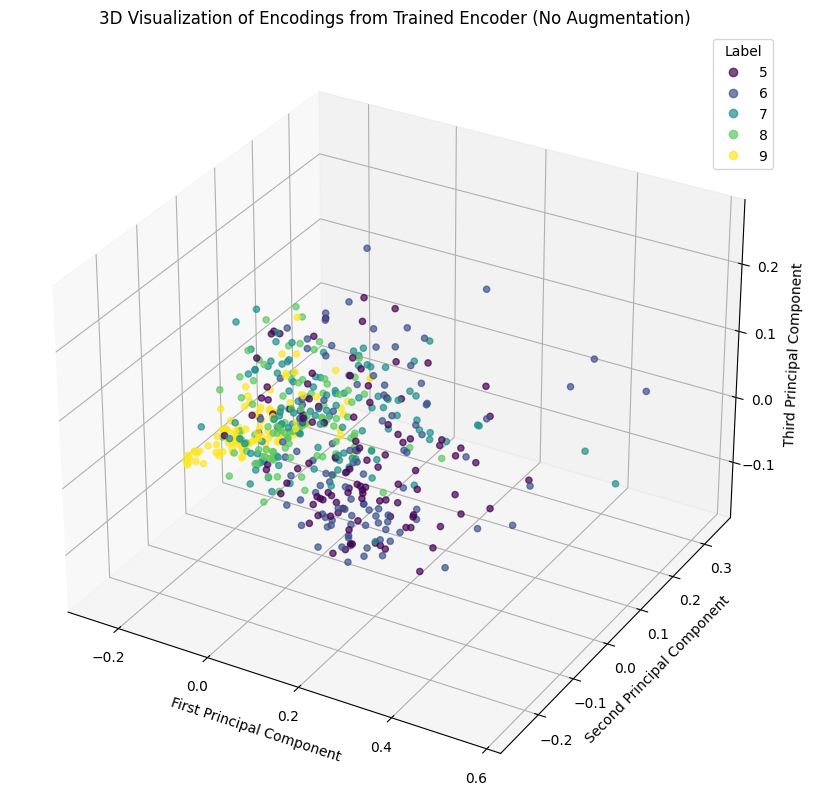

In [28]:
pca3d = PCA(n_components = 3)
principal_components3d = pca3d.fit_transform(enc_df.iloc[:,0:10])

plt.figure(figsize=(10,10))
ax = plt.axes(projection ='3d')
sc = ax.scatter(principal_components3d[:,0],principal_components3d[:,1],principal_components3d[:,2], 
           c=enc_df['Label'],alpha = 0.7 )

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
ax.set_title('3D Visualization of Encodings from Trained Encoder (No Augmentation)')
ax.legend(*sc.legend_elements(), title = 'Label')



Text(0.5, 1.0, '2D Visualization of Encodings from Trained Encoder (No Augmentation)')

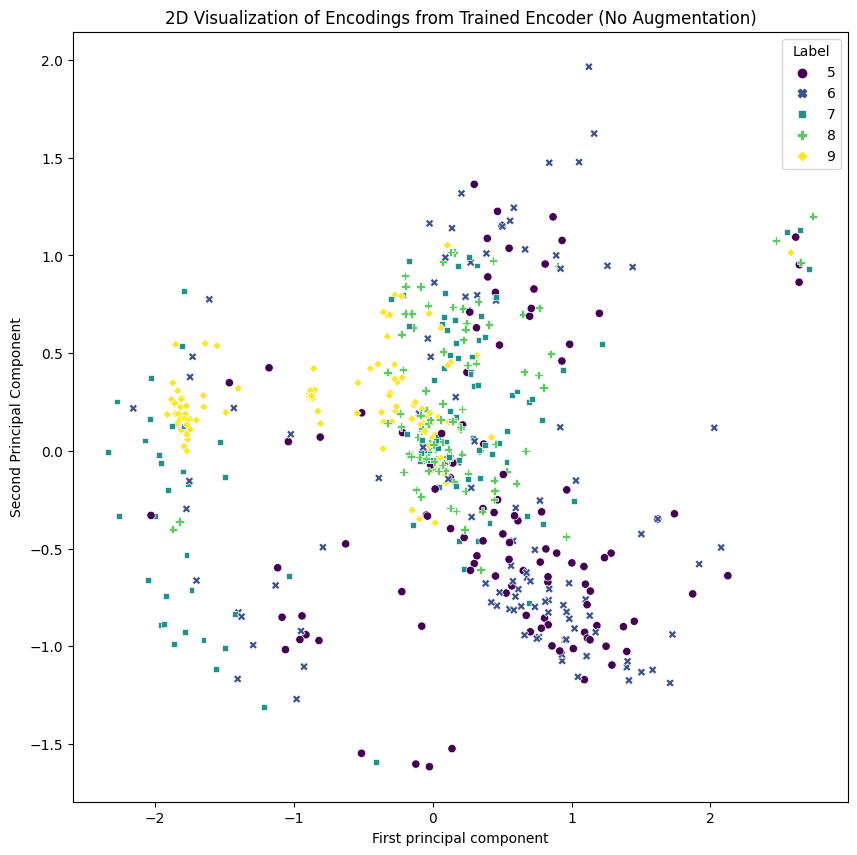

In [41]:

pca2d = PCA(n_components = 2)
principal_components2d = pca2d.fit_transform(enc_df.iloc[:,0:10])

plt.figure(figsize=(10,10))
sns.scatterplot(principal_components2d[:,0],principal_components2d[:,1], hue = enc_df['Label'],
                palette = 'viridis', style = enc_df['Label'])

plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('2D Visualization of Encodings from Trained Encoder (No Augmentation)')



## <b style="color: red;">TRAINING THE CLASSIFIERS</b>

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

LE = LabelEncoder()
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(MEAN, y, test_size=0.2, random_state=42 )
standard_scaler = StandardScaler()

X_train = standard_scaler.fit_transform(X_train_raw)
X_test = standard_scaler.transform(X_test_raw)

y_train = LE.fit_transform(y_train_raw)
y_test = LE.transform(y_test_raw)

### <b style="color: red;">RANDOM FOREST CLASSIFIER</b>

In [20]:
RF_search_space = {"bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(6, 10), # values of max_depth are integers from 6 to 20
        "max_features": Categorical(['auto']), 
        "min_samples_leaf": Integer(2, 8),
        "min_samples_split": Integer(2, 5),
        "n_estimators": Integer(350, 500)
    }
RF = RandomForestClassifier()
RF_bayes_search = BayesSearchCV(RF, RF_search_space, n_iter=50, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=5)
RF_bayes_search.fit(X_train, y_train) 
RF_y_pred = RF_bayes_search.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test, RF_y_pred))


Accuracy Score:  0.5740740740740741


### <b style="color:red;">SUPPORT VECTOR CLASSIFIER</b>

In [21]:
SVM = SVC()
SVM_search_space = {'C':Real(0.01,2),
                    'kernel':Categorical(['linear','rbf'])}
SVM_bayes_search = BayesSearchCV(SVM, SVM_search_space, n_iter = 50, n_jobs = -1, cv = cv,
                                scoring = 'accuracy')
SVM_bayes_search.fit(X_train, y_train)

SVM_y_pred = SVM_bayes_search.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test, SVM_y_pred))

Accuracy Score:  0.5648148148148148


### <b style="color: red;">NEAREST NEIGHBORS CLASSIFIER</b>

In [22]:

KNN = KNeighborsClassifier()
KNN_search_space = {'n_neighbors':Integer(37,39),
                  }
KNN_bayes_search = BayesSearchCV(KNN, KNN_search_space, n_iter = 50, n_jobs = -1, cv = cv, 
                                scoring ='accuracy')
KNN_bayes_search.fit(X_train, y_train)
KNN_y_pred = KNN_bayes_search.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test, KNN_y_pred))

Accuracy Score:  0.46296296296296297


### <b style="color: red;">LOGISTIC REGRESSION CLASSIFIER</b>

In [23]:

LR = LogisticRegression()
LR_search_space = {'C':Real(0.01,1),
                    'penalty':Categorical(['l2','none']),
                    'max_iter':Integer(50,150),
                    'l1_ratio': Real(0,1)}
LR_bayes_search = BayesSearchCV(LR, LR_search_space, n_iter = 50, n_jobs = -1, cv = 5,
                                scoring = 'accuracy')
LR_bayes_search.fit(X_train, y_train)

LR_y_pred = LR_bayes_search.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test,LR_y_pred))


Accuracy Score:  0.5648148148148148


### <b style="color: red;">EXTREME GRADIENT BOOST CLASSIFIER</b>

In [24]:


XGB = xgboost.XGBClassifier()

XGB_search_space = {
                   'max_depth':Integer(3,10),
                    'n_estimators':Integer(50,800)
                   }
XGB_bayes_search = BayesSearchCV(XGB, XGB_search_space, n_iter = 50, n_jobs = -1, cv = 5,
                                scoring = 'accuracy')
XGB_bayes_search.fit(X_train,y_train)

XGB_y_pred  = XGB_bayes_search.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test,XGB_y_pred ))

Accuracy Score:  0.5277777777777778


### <b style="color: red;">VOTING CLASSIFIER</b>

In [69]:

RF_params = dict(RF_bayes_search.best_params_)
KNN_params = dict(KNN_bayes_search.best_params_)
SVM_params = dict(SVM_bayes_search.best_params_)
LR_params = dict(LR_bayes_search.best_params_)
XGB_params = dict(XGB_bayes_search.best_params_)


estimator = []

estimator.append(('RF', RandomForestClassifier(bootstrap=RF_params['bootstrap'],
                                                max_depth=RF_params['max_depth'],
                                                max_features=RF_params['max_features'],
                                                min_samples_leaf = RF_params['min_samples_leaf'],
                                                min_samples_split=RF_params['min_samples_split'],
                                                n_estimators =  RF_params['n_estimators'])))

estimator.append(('SVM', SVC(C=SVM_params['C'],
                             kernel=SVM_params['kernel'],
                            probability=True)))

estimator.append(('XGB', xgboost.XGBClassifier(max_depth=XGB_params['max_depth'],
                                              n_estimators = XGB_params['n_estimators'],
                                              objective='multi: softprob')))
# estimator.append(('LR', LogisticRegression(C =LR_params['C'],
#                     penalty = LR_params['penalty'],
#                     max_iter = LR_params['max_iter'],
#                     l1_ratio = LR_params['l1_ratio'])))

VC_hard = VotingClassifier(estimators = estimator, voting = 'hard')
VC_soft = VotingClassifier(estimators = estimator, voting = 'soft')

VC_hard.fit(X_train, y_train)
VC_soft.fit(X_train, y_train)

VC_hard_pred = VC_hard.predict(X_test)
VC_soft_pred = VC_soft.predict(X_test)

print(f'VC_hard_accuracy: {accuracy_score(y_test,VC_hard_pred)}')
print(f'VC_soft_accuracy: {accuracy_score(y_test,VC_soft_pred)}')

VC_hard_accuracy: 0.5833333333333334
VC_soft_accuracy: 0.5370370370370371


## <b style="color: red;">EVALUATING PERFORMANCE ON TEST DATA</b>

In [21]:
rf = RandomForestClassifier(bootstrap = False, 
                       max_depth = 6,
                       max_features= 'auto',
                       min_samples_leaf = 2,
                       min_samples_split= 5,
                       n_estimators =  351)

svm = SVC(C=1.5469622015270963,
          kernel='rbf',
          probability=True)


xbg = xgboost.XGBClassifier(max_depth = 4,
                            n_estimators = 50, 
                            objective='multi: softprob')

lr = LogisticRegression(penalty = None,
                       C = 0.318,
                       max_iter= 60)

knn = KNeighborsClassifier(n_neighbors = 39)

estimator = []

estimator.append(('RF', RandomForestClassifier(bootstrap = False,
                                                max_depth = 6,
                                                max_features= 'auto',
                                                min_samples_leaf = 2,
                                                min_samples_split= 5,
                                                n_estimators =  351)))

estimator.append(('SVM', SVC(C=1.5469622015270963,
                             kernel='rbf',
                            probability=True)))

estimator.append(('XGB', xgboost.XGBClassifier(max_depth= 4,
                                              n_estimators = 50, 
                                              objective='multi: softprob')))

vc_hard = VotingClassifier(estimators = estimator, voting = 'hard')
vc_soft = VotingClassifier(estimators = estimator, voting = 'soft')




rf.fit(X_train,y_train)
svm.fit(X_train, y_train)
xbg.fit(X_train,y_train)
lr.fit(X_train,y_train)
knn.fit(X_train,y_train)
vc_hard.fit(X_train, y_train)
vc_soft.fit(X_train, y_train)


VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=6,
                                                     max_features='auto',
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=351)),
                             ('SVM',
                              SVC(C=1.5469622015270963, probability=True)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            ear...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi: softprob',
                                            predictor=None, ...))],
                 voting='soft')

In [7]:
#Create dataframe for test data images and labels
root_Dir_2 =       #root directory for test data

#Create an empty dataframe
df_2 = pd.DataFrame(columns=['image', 'label'])
#Iterate over the sub directories within the root directory
for dirs, subdirs, files in os.walk(root_Dir_2):
  for file in files:
    file_path = os.path.join(dirs, file)
    
    #load the image
    with Image.open(file_path) as img:
      #convert image to numpy array
      img_array = np.array(img)
      #Extract the label
      label = os.path.basename(dirs)
      #Add the image and label to the dataframe
      df_2 = df_2.append({'image':img_array, 'label':label}, ignore_index = True)
#df_2 = df_2.sample(frac = 1).reset_index(drop = True)
df_2.head(10)

,image,label
0,"[[[253, 255, 254], [245, 247, 246], [240, 244,...",5
1,"[[[254, 254, 252], [246, 242, 239], [252, 243,...",5
2,"[[[253, 254, 249], [244, 245, 237], [246, 247,...",5
3,"[[[248, 255, 255], [235, 239, 240], [253, 244,...",5
4,"[[[254, 253, 255], [245, 243, 246], [246, 238,...",5
5,"[[[255, 254, 255], [247, 243, 242], [251, 246,...",5
6,"[[[253, 253, 253], [251, 251, 251], [254, 254,...",5
7,"[[[255, 255, 250], [244, 243, 238], [241, 242,...",5
8,"[[[255, 252, 232], [245, 242, 225], [245, 240,...",5
9,"[[[244, 255, 247], [245, 252, 244], [247, 246,...",5


In [10]:
batch_size = 16
y_2 = df_2['label']
X_2 = df_2['image'].values
X_2 = np.stack(X_2)

X1_2 = preprocessing_model.predict(X_2)

MEAN_2,VAR_2 = enc.predict(X1_2, batch_size=batch_size)

2/2 [==============================] - 0s 40ms/step


In [24]:
#create dataframe of encodings of the test data
enc_df_2 = pd.DataFrame(MEAN_2)
enc_df_2['Label'] = y_2
# enc_df_2['Label'] = enc_df_2['Label'].apply(lambda x :int(x))
enc_df_2 = enc_df_2.sample(frac = 1).reset_index(drop = True)
enc_df_2.head()

,0,1,2,3,4,5,6,7,8,9,Label
0,-0.198624,-0.010695,-0.022333,0.003716,0.034145,0.519903,0.038669,0.008856,-0.061729,0.031485,7
1,0.679862,-0.041442,-0.020877,-0.035888,-0.027178,0.948364,0.087311,-0.017988,0.378300,-0.043368,8
2,0.576504,0.022929,-0.010875,-0.046402,-0.034390,0.688592,0.035642,0.000285,0.138517,-0.020640,9
3,-0.959362,-0.073546,0.008138,0.034828,-0.016782,0.919600,-0.155117,0.023487,1.185647,0.012037,5
4,0.558011,-0.007995,0.005547,-0.040850,0.009981,0.839708,0.083784,0.013073,0.139439,-0.001094,9


In [34]:
X_test_2 = standard_scaler.transform(enc_df_2.drop('Label', axis = 1))
y_test_2 = LE.transform(enc_df_2['Label'])

#predict and test accuracy for each classifier
pred_2 = rf.predict(X_test_2)


print(f'accuracy: {accuracy_score(y_test_2, pred_2)}')


accuracy: 0.65


In [27]:
#View precision, recall and f1-score for each classifier. 
from sklearn.metrics import classification_report
report = classification_report(y_test_2, pred_2)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        12
           1       0.58      0.58      0.58        12
           2       0.75      0.50      0.60        12
           3       0.55      1.00      0.71        12
           4       1.00      0.75      0.86        12

    accuracy                           0.67        60
   macro avg       0.71      0.67      0.66        60
weighted avg       0.71      0.67      0.66        60



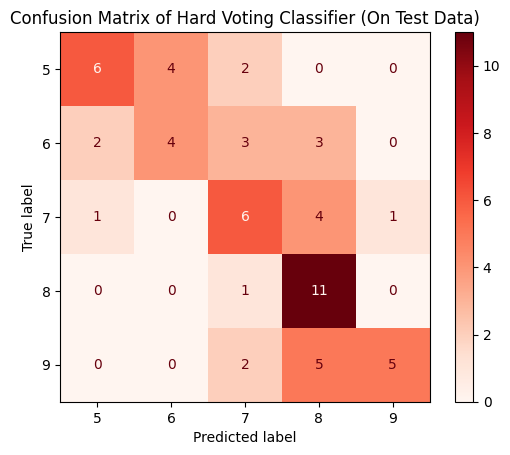

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test_2,VC_hard_pred_2,display_labels=[5,6,7,8,9], cmap = 'Reds')

## <b style="color: red;">RESNET COMPARISM</b>

In [4]:
def resnet(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')

    base_model = keras.applications.ResNet50V2(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                             input_shape=(256,256,3),
                                             include_top=False)
    base_model.trainable = False
    
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    prediction = keras.layers.Dense(5)(x)
    model = keras.Model(inputs,prediction, name = 'Resnet')
    
    return model

Resnet = resnet((256,256,3))
Resnet.summary()

Model: "Resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [5]:
Resnet.compile(optimizer = 'adam',
              loss = 'mse', metrics = ['accuracy'])
Resnet.fit(train_data, validation_data = val_data, epochs = 20 )

Epoch 1/20
31/31 [==============================] - 105s 3s/step - loss: 0.4512 - accuracy: 0.3306 - val_loss: 0.3364 - val_accuracy: 0.4000
Epoch 2/20
31/31 [==============================] - 93s 3s/step - loss: 0.2082 - accuracy: 0.5408 - val_loss: 0.2397 - val_accuracy: 0.4200
Epoch 3/20
31/31 [==============================] - 93s 3s/step - loss: 0.1686 - accuracy: 0.5918 - val_loss: 0.2101 - val_accuracy: 0.4800
Epoch 4/20
31/31 [==============================] - 94s 3s/step - loss: 0.1551 - accuracy: 0.6265 - val_loss: 0.2085 - val_accuracy: 0.3800
Epoch 5/20
31/31 [==============================] - 93s 3s/step - loss: 0.1406 - accuracy: 0.6388 - val_loss: 0.2071 - val_accuracy: 0.4600
Epoch 6/20
31/31 [==============================] - 93s 3s/step - loss: 0.1358 - accuracy: 0.6429 - val_loss: 0.2110 - val_accuracy: 0.4200
Epoch 7/20
31/31 [==============================] - 93s 3s/step - loss: 0.1206 - accuracy: 0.7061 - val_loss: 0.1762 - val_accuracy: 0.5000
Epoch 8/20
31/31 [=

In [11]:
res_pred = Resnet.predict(X1_2)

2/2 [==============================] - 10s 4s/step


In [15]:
print(f'accuracy: {accuracy_score(y_2.astype(int) - 5 , np.argmax(res_pred, axis=1))}')



accuracy: 0.5666666666666667
